Goal: use a linear regression model to try to predict the relaxed energy of catalysts. 

Pipeline:
1. data inspection & cleaning
2. correlation analysis (feature reduction)
3. principal component analysis (for visualization)
4. cross validation
5. hyperparameter tuning & model selection
6. final model evaluation
7. feature importance
8. exploitation

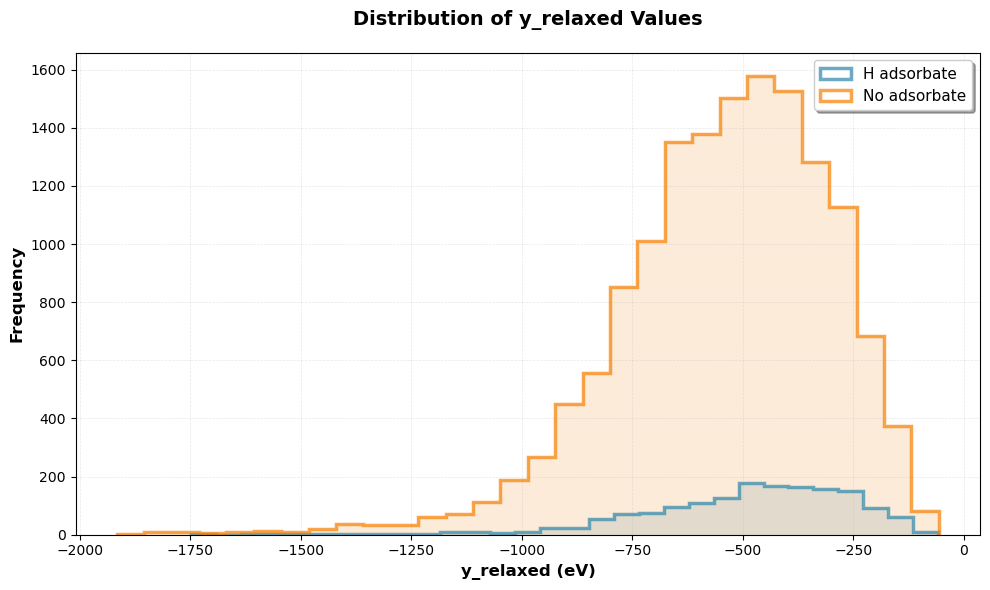

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# load datasets; using only compositional features because structural features
# are missing for a lot of samples; this needs to be looked into later.
# perhaps train two models on no-ads dataset
# one using composition + structure features
# one using only composition features

df_h = pd.read_csv('training_FULL_h_comp_featurized.csv')
df_no_ads = pd.read_csv('training_FULL_no_ads_comp_featurized.csv')

# Create figure with better size and resolution
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

# Plot histograms as step curves (no overlap issues)
ax.hist(df_h['y_relaxed'], bins=30, alpha=0.7, color='#2E86AB', label='H adsorbate', histtype='step', linewidth=2.5)
ax.hist(df_no_ads['y_relaxed'], bins=30, alpha=0.7, color='#F77F00', label='No adsorbate', histtype='step', linewidth=2.5)

# Optional: add fill under the lines for better visibility
ax.hist(df_h['y_relaxed'], bins=30, alpha=0.15, color='#2E86AB', histtype='stepfilled')
ax.hist(df_no_ads['y_relaxed'], bins=30, alpha=0.15, color='#F77F00', histtype='stepfilled')

# Add labels and title
ax.set_xlabel('y_relaxed (eV)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Distribution of y_relaxed Values', fontsize=14, fontweight='bold', pad=20)

# Improve legend
ax.legend(loc='upper right', frameon=True, shadow=True, fontsize=11)

# Add grid for better readability
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Improve tick labels
ax.tick_params(axis='both', which='major', labelsize=10)

# Tight layout to prevent label cutoff
plt.tight_layout()
plt.show()

In [45]:
# check features (columns) with all NaN values
nan_columns_h = df_h.columns[df_h.isna().all()].tolist()
nan_columns_no_ads = df_no_ads.columns[df_no_ads.isna().all()].tolist()

print("Columns with all NaN values in H adsorbate dataset:", nan_columns_h)
print("Columns with all NaN values in No adsorbate dataset:", nan_columns_no_ads)

# drop NaN columns
df_h_no_nan = df_h.drop(columns=nan_columns_h)
df_no_ads_no_nan = df_no_ads.drop(columns=nan_columns_no_ads)

print(f"comp features in h-ads dataset: {df_h_no_nan.shape[1]}")
print(f"comp features in no-ads dataset: {df_no_ads_no_nan.shape[1]}")

Columns with all NaN values in H adsorbate dataset: ['ElementProperty Exceptions', 'Weight Fraction', 'Atomic Fraction', 'Yang delta', 'Yang omega', 'APE mean', 'Radii local mismatch', 'Radii gamma', 'Configuration entropy', 'Atomic weight mean', 'Total weight', 'Lambda entropy', 'Electronegativity delta', 'Electronegativity local mismatch', 'VEC mean', 'Mixing enthalpy', 'Mean cohesive energy', 'Interant electrons', 'Interant s electrons', 'Interant p electrons', 'Interant d electrons', 'Interant f electrons', 'Shear modulus mean', 'Shear modulus delta', 'Shear modulus local mismatch', 'Shear modulus strength model']
Columns with all NaN values in No adsorbate dataset: ['ElementProperty Exceptions', 'Weight Fraction', 'Atomic Fraction', 'Yang delta', 'Yang omega', 'APE mean', 'Radii local mismatch', 'Radii gamma', 'Configuration entropy', 'Atomic weight mean', 'Total weight', 'Lambda entropy', 'Electronegativity delta', 'Electronegativity local mismatch', 'VEC mean', 'Mixing enthalpy'

Lot of features failed to calculate. It seems some featurizers did not work well. Train the model and see how it performs, then revise the featurization step. 

In [47]:
# drop non-numeric columns and index column
df_h_corr = df_h_no_nan.drop(columns=['bulk_id', 'bulk_symbols', 'y_relaxed']).drop(columns=[df_h_no_nan.columns[0]])
df_h_corr.head()

,MagpieData mean AtomicWeight,MagpieData mean MeltingT,MagpieData mean CovalentRadius,MagpieData mean Electronegativity,MagpieData mean NsValence,MagpieData mean NpValence,MagpieData mean NdValence,MagpieData mean NfValence,MagpieData mean NValence,MagpieData mean NsUnfilled,...,Ts,Og,transition metal fraction,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,band center
0,48.696267,491.838333,90.333333,3.001667,1.666667,3.166667,3.333333,0.0,8.166667,0.000000,...,0,0,0.166667,3,0.707107,0.673540,0.666927,0.666678,0.666667,6.416770
1,32.105391,327.357143,110.571429,2.211429,1.714286,1.714286,2.857143,0.0,6.285714,0.285714,...,0,0,0.000000,3,0.589015,0.500485,0.449086,0.435403,0.430035,4.984547
2,74.306440,924.680000,112.800000,2.622000,2.000000,2.400000,1.000000,2.8,8.200000,0.000000,...,0,0,0.200000,3,0.663325,0.614463,0.600984,0.600078,0.600002,5.403931
3,37.710433,643.041667,89.166667,2.965000,1.666667,2.666667,2.666667,0.0,7.000000,0.000000,...,0,0,0.333333,3,0.707107,0.673540,0.666927,0.666678,0.666667,6.220992
4,40.689700,373.740000,94.000000,2.545000,2.000000,2.000000,5.000000,0.0,9.000000,0.000000,...,0,0,0.000000,2,0.707107,0.629961,0.574349,0.552045,0.535887,5.951264


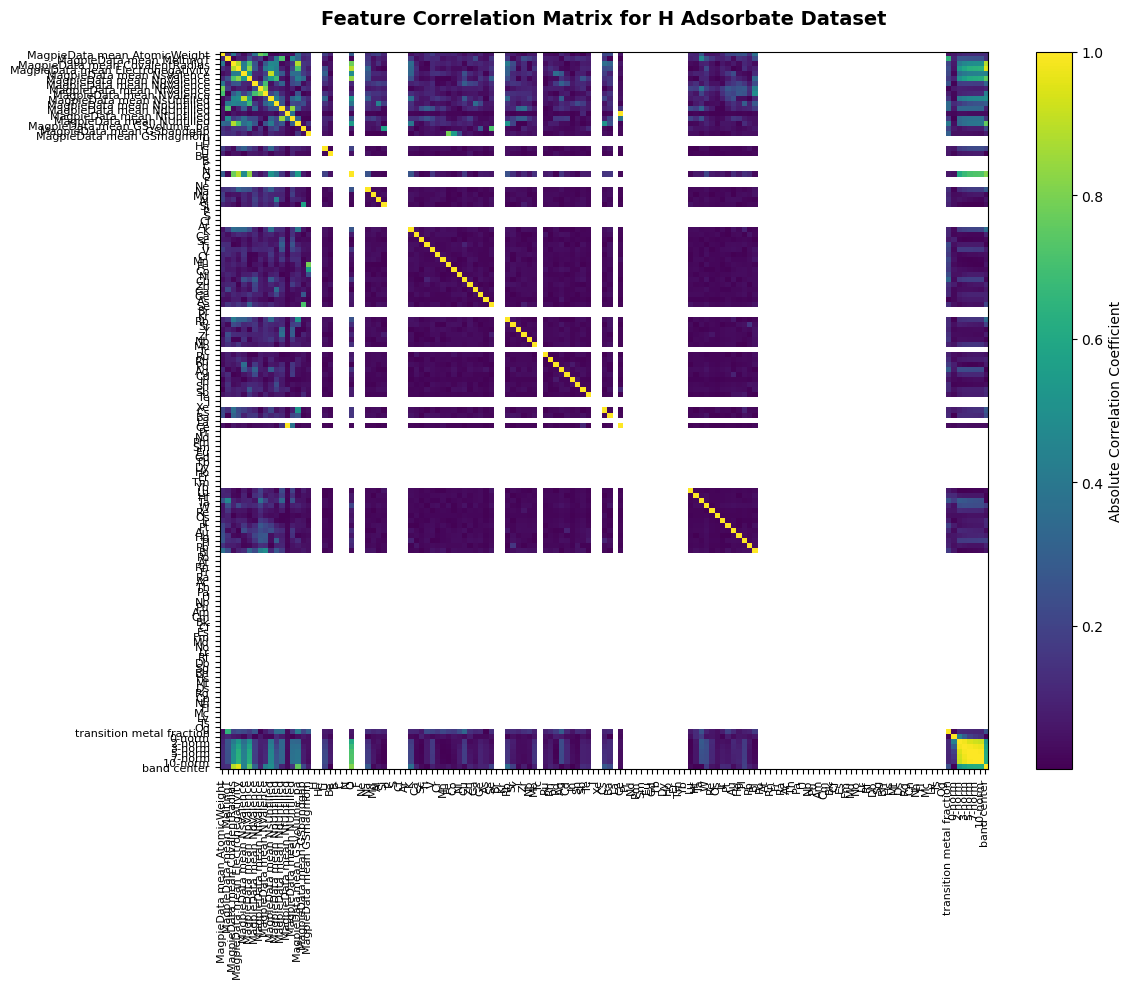

In [50]:
h_corr_mat = df_h_corr.corr().abs()

# visualize the correlation matrix
plt.figure(figsize=(12, 10), dpi=100)
plt.imshow(h_corr_mat, cmap='viridis', aspect='auto')
plt.colorbar(label='Absolute Correlation Coefficient')
plt.title('Feature Correlation Matrix for H Adsorbate Dataset', fontsize=14, fontweight='bold', pad=20)
plt.xticks(ticks=range(len(h_corr_mat.columns)), labels=h_corr_mat.columns, rotation=90, fontsize=8)
plt.yticks(ticks=range(len(h_corr_mat.index)), labels=h_corr_mat.index, fontsize=8)
plt.tight_layout()
plt.show()  